In [2]:
"""Import all modules"""
from __future__ import print_function
from six.moves import cPickle as pickle
from six.moves import range
from six.moves.urllib.request import urlretrieve
from IPython.display import display
from scipy import ndimage
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
import tarfile
import h5py
from PIL import Image
%matplotlib inline

In [64]:
"""Download the train,test and extra dataset """
url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  return filename

train_filename = maybe_download('train.tar.gz')
test_filename = maybe_download('test.tar.gz')


print("Success")

Success


In [65]:
"""Extract dataset files"""
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = root
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)


train already present - Skipping extraction of train.tar.gz.
train
test already present - Skipping extraction of test.tar.gz.
test


In [66]:
"""Create a python dictionary for bounded box indormation"""
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox
    
    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result
    
print("Success")

Success


In [67]:
digitFileTrain=DigitStructFile(os.path.join('train','digitStruct.mat'))
digitFileTest=DigitStructFile(os.path.join('test','digitStruct.mat'))

train_data=digitFileTrain.getAllDigitStructure_ByDigit()
test_data=digitFileTest.getAllDigitStructure_ByDigit()


print("Success")
print(train_data[1])


Success
{'boxes': [{'width': 23.0, 'top': 29.0, 'label': 2.0, 'left': 77.0, 'height': 32.0}, {'width': 26.0, 'top': 25.0, 'label': 3.0, 'left': 98.0, 'height': 32.0}], 'filename': '2.png'}


In [68]:
def getlabel(datas):
    tlabel=np.ndarray(shape=[len(datas),5],dtype=np.int32)
    tbox=np.ndarray(shape=[len(datas),5,4],dtype=np.float32)
    for i in range(len(datas)):
        k=int(datas[i]['filename'][0:(len(datas[i]['filename'])-4)])-1
        for j in range(5):
            if j>=len(datas[i]['boxes']):
                tlabel[k,j]=0
                tbox[k,j,0]=0
                tbox[k,j,1]=0
                tbox[k,j,2]=0
                tbox[k,j,3]=0
            else:
                tlabel[k,j]=datas[i]['boxes'][j]['label']
                tbox[k,j,0]=datas[i]['boxes'][j]['width']
                tbox[k,j,1]=datas[i]['boxes'][j]['top']
                tbox[k,j,2]=datas[i]['boxes'][j]['left']
                tbox[k,j,3]=datas[i]['boxes'][j]['height']
    return tlabel,tbox
trainlabel,trainbox=getlabel(train_data)
testlabel,testbox=getlabel(test_data)

In [69]:
my_label=np.ndarray(shape=[5,5],dtype=np.int32)

my_label[0,:]=[7,3,1,0,0]
my_label[1,:]=[7,3,1,0,0]
my_label[2,:]=[7,9,6,0,0]
my_label[3,:]=[5,7,3,0,0]
my_label[4,:]=[2,4,0,0,0]
print(my_label)

my_box=np.ndarray(shape=[5,5,4],dtype=np.float32)
for i1 in range(5):
    for i2 in range(5):
        for i3 in range(4):
            my_box[i1,i2,i3]=0
print(my_box)

[[7 3 1 0 0]
 [7 3 1 0 0]
 [7 9 6 0 0]
 [5 7 3 0 0]
 [2 4 0 0 0]]
[[[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]]


In [70]:
"""Create a pickle file to store processed data"""
pickle_file = 'SVHN_labelboxall.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_label': trainlabel,
        'train_box': trainbox,
        'test_label': testlabel,
        'test_box': testbox,
        
      }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [3]:
pickle_file = 'SVHN_labelboxall.pickle'
try:
    f = open(pickle_file, 'r')
    save = pickle.load(f)
    trainlabel=save['train_label']
    trainbox=save['train_box']
    testlabel=save['test_label']
    testbox=save['test_box']
except Exception as e:
    print('Unable to load data to', pickle_file, ':', e)
    raise    
    

In [4]:
my_label=np.ndarray(shape=[5,5],dtype=np.int32)

my_label[0,:]=[7,3,1,0,0]
my_label[1,:]=[7,3,1,0,0]
my_label[2,:]=[7,9,6,0,0]
my_label[3,:]=[5,7,3,0,0]
my_label[4,:]=[2,4,0,0,0]
print(my_label)

my_box=np.ndarray(shape=[5,5,4],dtype=np.float32)
for i1 in range(5):
    for i2 in range(5):
        for i3 in range(4):
            my_box[i1,i2,i3]=0
print(my_box)

[[7 3 1 0 0]
 [7 3 1 0 0]
 [7 9 6 0 0]
 [5 7 3 0 0]
 [2 4 0 0 0]]
[[[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]]


In [5]:
# load and resize the pictures to 32*32

pic_dir=os.getcwd()
def getpics(filedir):
    data_folders=[os.path.join(filedir,x) for x in sorted(os.listdir(filedir))]
    return data_folders
train_pic=getpics(pic_dir+'/train')
test_pic=getpics(pic_dir+'/test')
my_pic=getpics(pic_dir+'/mydata')
#sample_pic=getpics(pic_dir+'/sample')
print(os.path.basename(train_pic[3]))
print(len(train_pic))
print(pic_dir)


1000.png
33402
/media/senlyu/Project/digit_recognition


In [6]:
import time

In [ ]:
def checkpics(pics):
    maxd,mind=0,0
    for pic in pics:
        im = Image.open(pic)
        y=im.size[0]
        x=im.size[1]
        image_data=ndimage.imread(pic).astype(float)
        for i in range(x):
            for j in range(y):
                for k in range(3):
                    maxd,mind=max(maxd,image_data[i,j,k]),min(mind,image_data[i,j,k])
    return maxd,mind
maxtrainx,mintrainx=checkpics(train_pic)
maxtestx,mintestx=checkpics(train_pic)
print(maxtrainx,mintrainx)
print(maxtestx,mintestx)

In [ ]:
"""Get all the images"""
image_size=64
pixel_depth=255.0
color_channels=3

def imageave(data,x,y,xl,yl,k,xsize,ysize):
    c=0.0
    kk=0
    if xl>1 and yl>1:
        for i in range(xl):
            for j in range(yl):
                if (x*xl+i)>=xsize or (y*yl+j)>=ysize:
                    kk+=1
                else:
                    c+=data[x*xl+i,y*yl+j,k]
        if kk==xl*yl:
            c=0
        else:
            c=c/(xl*yl-kk)
    elif xl==1 and yl>1:
        for i in range(yl):
            if (y*yl+i)>=ysize:
                kk+=1
            else:
                c+=data[x,y*yl+i,k]
        if kk==yl:
            c=0
        else:
            c=c/(yl-kk)            
    elif yl==1 and xl>1:
        for i in range(xl):
            if (x*xl+i)>=xsize:
                kk+=1
            else:
                c+=data[x*xl+i,y,k]
        if kk==xl:
            c=0
        else:
            c=c/(xl-kk)
    else:
        c=data[x,y,k]

    c=c/pixel_depth
    newdata=c
    return newdata

def resizeton(x,y,data):
    xn=x/image_size+1
    yn=y/image_size+1
    newdata=np.ndarray(shape=(image_size,image_size,color_channels),dtype=np.float32)
    for i in range(image_size):
        for j in range(image_size):
            for k in range(color_channels):
                if i>(x-1) or j>(y-1):
                    newdata[i,j,k]=0
                else:
                    newdata[i,j,k]=imageave(data,i,j,xn,yn,k,x,y)            
    return newdata

def loadpics(pics,box):
    box1=np.ndarray(shape=[len(box),5,4],dtype=np.float32)
    for i in range(len(box)):
        for j in range(5):
            for k in range(4):
                box1[i,j,k]=0
    dataset=np.ndarray(shape=(len(pics),image_size,image_size,color_channels),dtype=np.float32)
    for pic in pics:
        im = Image.open(pic)
        y=im.size[0]
        x=im.size[1]
        image_data=ndimage.imread(pic).astype(float)
        k=int(os.path.basename(pic)[0:len(os.path.basename(pic))-4])-1
        new_data=resizeton(x,y,image_data)
        for j in range(5):             
            box1[k,j,0]=box[k,j,0]/im.size[0]*image_size
            box1[k,j,1]=box[k,j,1]/im.size[1]*image_size
            box1[k,j,2]=box[k,j,2]/im.size[0]*image_size
            box1[k,j,3]=box[k,j,3]/im.size[1]*image_size
            if box1[k,j,0]>image_size:
                box1[k,j,0]=image_size
            elif box1[k,j,0]<0:
                box1[k,j,0]=0
            if box1[k,j,1]>image_size:
                box1[k,j,1]=image_size
            elif box1[k,j,1]<0:
                box1[k,j,1]=0
            if box1[k,j,2]>image_size:
                box1[k,j,2]=image_size
            elif box1[k,j,2]<0:
                box1[k,j,2]=0
            if box1[k,j,3]>image_size:
                box1[k,j,3]=image_size
            elif box1[k,j,3]<0:
                box1[k,j,3]=0
        dataset[k]=new_data
    return dataset,box1

start=time.time()
strain_dataset,train_box=loadpics(train_pic,trainbox)
end=time.time()
print(end-start)

start=time.time()
stest_dataset,test_box=loadpics(test_pic,testbox)
end=time.time()
print(end-start)

start=time.time()
my_dataset,my_box=loadpics(my_pic,my_box)
end=time.time()
print(end-start)

print('success')

In [ ]:
"""Create a pickle file to store all data"""
pickle_file='SVHN_alldata.pickle'
try:
    f=open(pickle_file,'wb')
    save={
        'train_dataset': strain_dataset,
        'train_label': trainlabel,
        'train_box': train_box,
        'test_dataset': stest_dataset,
        'test_label': testlabel,
        'test_box': test_box,
        'my_dataset': my_dataset,
        'my_label':my_label,
        'my_box':my_box,
    }
    pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
    f.close()
    print('success')
except Exception as e:
    print('unable to save')
    raise

In [116]:
pickle_file='SVHN_alldata.pickle'
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    strain_datasets=save['train_dataset']
    strain_labels=save['train_label']
    stest_datasets=save['test_dataset']
    stest_labels=save['test_label']


1232
[1 7 8 0 0]


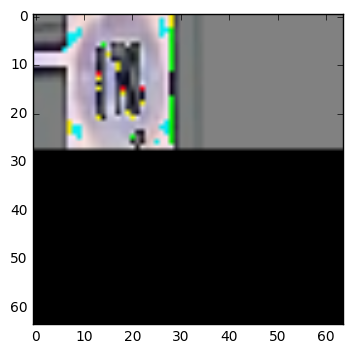

In [117]:
import random
i=random.randrange(0,len(stest_dataset))
print(i)
plt.figure()
plt.imshow(stest_dataset[i])
print(stest_labels[i])